In [ ]:
!pip install plotly

In [5]:
import time
import os
import shutil
from itertools import islice
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import findspark
findspark.init()

from google.cloud import storage

spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "16g") \
    .config("spark.driver.maxResultSize", "16g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "4") \
    .config("spark.dynamicAllocation.maxExecutors", "100") \
    .getOrCreate()



spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

print(spark.version)

3.1.3


# Read from folder into spark df

You will see 5 sub-folders, each containing a collection of parquet files.  A single folder can be read into Spark Dataframe:

* Commits (gs://msca-bdp-data-open/final_project_git/commits): This contains information about the commits made to repositories. Each commit has metadata such as the author, committer, commit date, SHA, parent commit(s), and commit message.

* Contents (gs://msca-bdp-data-open/final_project_git/contents): Provides the content of the files in the repositories. This is useful if you're looking to analyze source code or documents within repositories.

* Files (gs://msca-bdp-data-open/final_project_git/files): This contains metadata about the files in the repositories such as the file path, the mode, and the blob ID which links back to the content.

* Languages (gs://msca-bdp-data-open/final_project_git/languages): Each repository often has code written in one or more languages. This table provides an aggregation of the number of bytes of code for each language in a repository.

* Licenses (gs://msca-bdp-data-open/final_project_git/licenses): Contains information on the licenses used by repositories.
 

In [18]:
#!hadoop fs -ls "gs://msca-bdp-data-open/final_project_git/commits"

In [6]:
# Read into spark df
%time
commits_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/commits")
contents_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/contents")
files_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/files")
languages_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/languages")
licenses_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/licenses")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 9.06 µs


In [7]:
# Checking preliminary data schema
%time
tables = [commits_spDf,contents_spDf,files_spDf,languages_spDf,licenses_spDf]

for i in tables:
    print(f"Table \n {i}")
    i.printSchema()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


Table 
 +--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------+
|              commit|                tree|              parent|              author|           committer|             subject|             message|             trailer|difference|difference_truncated|           repo_name|encoding|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------+
|aa358905a1b12c6fa...|df3f8bf61bf1cb0df...|[ea230a45a0e97e4d...|{conda-forge-coor...|{conda-forge-coor...|Updated the qceng...|Updated the qceng...|                  []|        []|                true|[conda-forge/feed...|    null|
|5a6b6d6d29489f858...|ff89accb7e283ca88...|[4ee369feb64ee97d...|

Table 
 +--------------------+-------+--------------------+------+------+
|                  id|   size|             content|binary|copies|
+--------------------+-------+--------------------+------+------+
|d5b1049fdaa182fa5...|   1570|{"version":3,"sou...| false|   256|
|896830f9ea31efd6b...|  18616|                null|  true|     1|
|bf1e2a8490344601c...|  15580|                null|  true|     1|
|e5976431eba91aa73...|   3328|                null|  true|     1|
|311532e41682cab22...|   8970|                null|  true|     1|
|0f9f37090068023bc...|1060956|                null|  true|     1|
|9c78cf443f6f6c6fc...|  11208|                null|  true|     1|
|54f06fa18833e05a2...|    861|                null|  true|     1|
|fbf679e412e05e886...|    875|                null|  true|     1|
|74bc061ff301a4296...| 107097|                null|  true|     1|
|d665767b64cd53744...|  19641|                null|  true|     1|
|250d48293d0d0f437...|  60649|                null|  true|     1|
|3

Table 
 +--------------------+-----------------+--------------------+-----+--------------------+--------------+
|           repo_name|              ref|                path| mode|                  id|symlink_target|
+--------------------+-----------------+--------------------+-----+--------------------+--------------+
|    enzbang/diouzhtu|refs/heads/master|gwiad_wiki_servic...|33261|49365044eed287691...|          null|
|TheMrNomis/Latex-...|refs/heads/master|             LFM.php|33261|ef8cb78feed7f2111...|          null|
|TheMrNomis/Latex-...|refs/heads/master|PHP/LatexFlavored...|33261|d989ce59652f57efa...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJPu...|33261|85268b90caa19efa2...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/uexJPus...|33261|e1623bb9d8dc7db60...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJPu...|33261|28a191eb0791ad2b0...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJP

Table 
 +--------------------+------------+
|           repo_name|    language|
+--------------------+------------+
|   lemi136/puntovent|   [{C, 80}]|
|      taxigps/nctool| [{C, 4461}]|
|         ahy1/strbuf| [{C, 5573}]|
| nleiten/mod_rpaf-ng|[{C, 30330}]|
| kmcallister/alameda|[{C, 17077}]|
|       TianYJ1/Snake|[{C, 10381}]|
|      doctorfree/Lds|[{C, 56413}]|
|SumiMakito/ReinaJ...| [{C, 7444}]|
|    serprex/rainbeam| [{C, 1964}]|
|   pdigiglio/oracolo| [{C, 1966}]|
|         jrb/vtclock|[{C, 23053}]|
|AhmedZanam/logica...| [{C, 1466}]|
|        ilardm/tsync|[{C, 64229}]|
|         lxzhu/runos|[{C, 21102}]|
|phillipgreenii/ir...| [{C, 3034}]|
|themaddoctor1/Mul...| [{C, 7774}]|
|Mr-Kumar-Abhishek...|  [{C, 233}]|
|tidatida/Small-Op...| [{C, 1664}]|
|magnusviri/matrix...|[{C, 93643}]|
|Atalanta/run-leng...|  [{C, 756}]|
+--------------------+------------+
only showing top 20 rows

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element

# EDA
What is the timeline of the data?  Do you see significant peaks and valleys?

Do you see any data collection gaps?

Do you see any outliers?  Remove obvious outliers before plotting the timeline

Do you see any spikes?  Are these spikes caused by real activities / events?

In [8]:
from pyspark.sql.functions import col, from_unixtime

# Extract commit timestamp
commits_spDf = commits_spDf.withColumn("author_timestamp", from_unixtime(col("author.date.seconds")))
commits_spDf = commits_spDf.withColumn("committer_timestamp", from_unixtime(col("committer.date.seconds")))
commits_spDf = commits_spDf.withColumn("author_commit_date", col("author_timestamp").cast("date"))
commits_spDf = commits_spDf.withColumn("committer_commit_date", col("committer_timestamp").cast("date"))

# View sample data
commits_spDf.select("committer_timestamp", "author_timestamp").show(5)

+-------------------+-------------------+
|committer_timestamp|   author_timestamp|
+-------------------+-------------------+
|2022-03-15 15:11:13|2022-03-15 15:11:13|
|2011-12-09 15:05:17|2011-12-09 15:05:17|
|2011-04-27 17:17:23|2011-04-27 17:17:23|
|2022-01-26 12:39:56|2022-01-26 12:39:56|
|2014-03-06 04:30:00|2014-03-06 04:30:00|
+-------------------+-------------------+
only showing top 5 rows



In [9]:
commits_spDf.select("committer_commit_date", "author_commit_date").show(5)

+---------------------+------------------+
|committer_commit_date|author_commit_date|
+---------------------+------------------+
|           2022-03-15|        2022-03-15|
|           2011-12-09|        2011-12-09|
|           2011-04-27|        2011-04-27|
|           2022-01-26|        2022-01-26|
|           2014-03-06|        2014-03-06|
+---------------------+------------------+
only showing top 5 rows



In [10]:
from pyspark.sql.functions import count

# Aggregate by date
author_timeline_df = commits_spDf.groupBy("author_commit_date").agg(count("*").alias("author_commit_count"))
committer_timeline_df = commits_spDf.groupBy("committer_commit_date").agg(count("*").alias("committer_commit_count"))

# Sort by date for visualization
author_timeline_df = author_timeline_df.orderBy("author_commit_date")
author_timeline_df.show(10)

committer_timeline_df = committer_timeline_df.orderBy("committer_commit_date")
committer_timeline_df.show(10)

+------------------+-------------------+
|author_commit_date|author_commit_count|
+------------------+-------------------+
|              null|              26300|
|        1970-01-01|                234|
|        1970-01-02|                 31|
|        1970-01-03|                  8|
|        1970-01-04|                 13|
|        1970-01-05|                 12|
|        1970-01-06|                 13|
|        1970-01-07|                  4|
|        1970-01-08|                  2|
|        1970-01-09|                  1|
+------------------+-------------------+
only showing top 10 rows



+---------------------+----------------------+
|committer_commit_date|committer_commit_count|
+---------------------+----------------------+
|                 null|                 26365|
|           1970-01-01|                   214|
|           1970-01-02|                    21|
|           1970-01-03|                     7|
|           1970-01-04|                     6|
|           1970-01-05|                    10|
|           1970-01-06|                     2|
|           1970-01-07|                     4|
|           1970-01-08|                     1|
|           1970-01-09|                     1|
+---------------------+----------------------+
only showing top 10 rows



In [33]:
author_timeline_pdDf = author_timeline_df.toPandas()

In [34]:
display(author_timeline_pdDf.head(5))
display(author_timeline_pdDf.tail(50))

,author_commit_date,author_commit_count
0,None,26300
1,1970-01-01,234
2,1970-01-02,31
3,1970-01-03,8
4,1970-01-04,13


,author_commit_date,author_commit_count
25068,2050-12-02,3
25069,2050-12-05,3
25070,2050-12-06,3
25071,2050-12-07,3
25072,2050-12-08,3
25073,2050-12-09,3
25074,2050-12-12,3
25075,2050-12-13,3
25076,2050-12-14,3
25077,2050-12-15,3


In [35]:
committer_timeline_pdDf = committer_timeline_df.toPandas()

In [36]:
display(committer_timeline_pdDf.head(5))
display(committer_timeline_pdDf.tail(50))

,committer_commit_date,committer_commit_count
0,None,26365
1,1970-01-01,214
2,1970-01-02,21
3,1970-01-03,7
4,1970-01-04,6


,committer_commit_date,committer_commit_count
24832,2037-12-26,1
24833,2037-12-27,1
24834,2037-12-28,1
24835,2037-12-29,1
24836,2037-12-30,1
24837,2037-12-31,1
24838,2038-01-01,5
24839,2038-01-02,1
24840,2038-01-03,1
24841,2038-01-04,1


In [41]:
pdDf = [author_timeline_pdDf, committer_timeline_pdDf]
titles = ['author','committer']

In [38]:
for df, val in zip(pdDf, titles):
    df['Date'] = pd.to_datetime(df[f'{val}_commit_date'])
    #df = df.dropna(inplace=True)
    print(f"For table {val}")
    print(f"Earliest commit date in record is {df['Date'].min()}")
    print(f"Latest commit date in record is {df['Date'].max()}")

For table author
Earliest commit date in record is 1970-01-01 00:00:00
Latest commit date in record is 2245-02-21 00:00:00
For table committer
Earliest commit date in record is 1970-01-01 00:00:00
Latest commit date in record is 2245-02-21 00:00:00


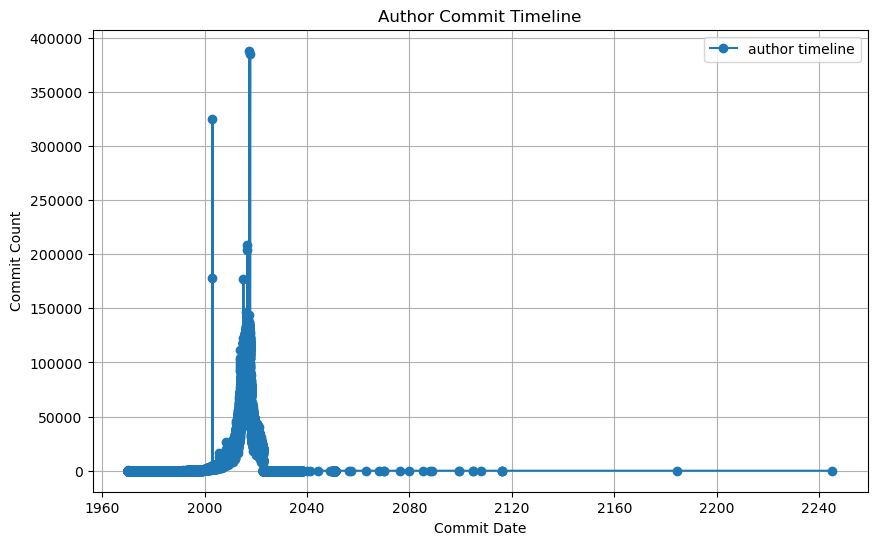

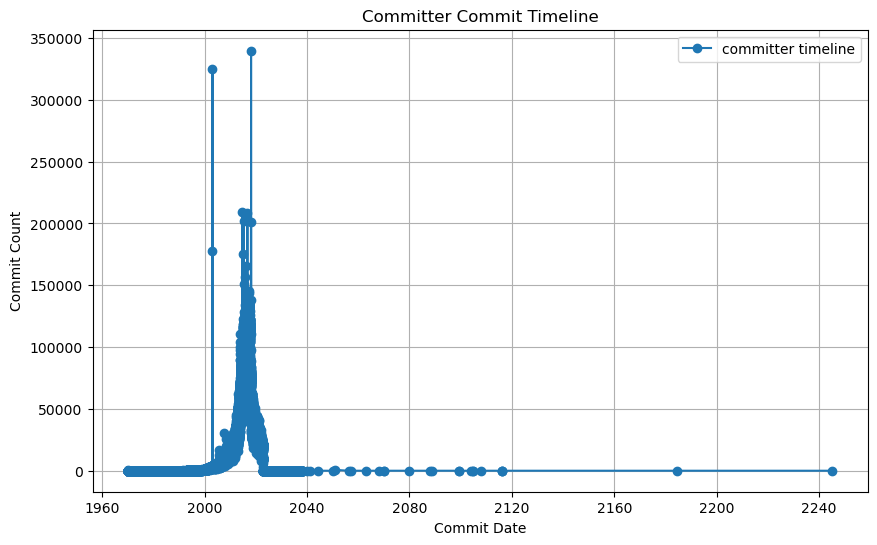

In [45]:
for df, title in zip(pdDf, titles):
    x_col = f'{title}_commit_date'
    y_col = f'{title}_commit_count'
    
    df[x_col] = pd.to_datetime(df[x_col])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col], marker='o', label=f'{title} timeline')
    
    # Adding labels and title
    plt.xlabel('Commit Date')
    plt.ylabel('Commit Count')
    plt.title(f'{title.capitalize()} Commit Timeline')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [80]:
committer_timeline_pdDf.tail(5560)

,committer_commit_date,committer_commit_count,Date
19322,2022-11-25,6168,2022-11-25
19323,2022-11-26,2840,2022-11-26
19324,2022-11-27,2,2022-11-27
19325,2022-11-28,2,2022-11-28
19326,2022-11-29,2,2022-11-29
...,...,...,...
24877,2116-03-01,2,2116-03-01
24878,2116-03-02,6,2116-03-02
24879,2116-03-03,4,2116-03-03
24880,2184-06-14,1,2184-06-14


# Remove outliar that is likely to be errors

Now notice that there are a lot of future dates after 2022-11-27 that have only 2 counts. We don't want to see because they are likely errors. So we decide to filter out dates on and after 2022-11-27.

In [11]:
# Filter rows where the dates are before 2022-11-27
from pyspark.sql.functions import year,col

cutoff_date = "2022-11-27"
commits_spDf = commits_spDf.filter((col("author_timestamp") < cutoff_date) & (col("committer_timestamp") < cutoff_date))

# View the filtered data
commits_spDf.select("committer_timestamp", "author_timestamp").show(5)

+-------------------+-------------------+
|committer_timestamp|   author_timestamp|
+-------------------+-------------------+
|2022-03-15 15:11:13|2022-03-15 15:11:13|
|2011-12-09 15:05:17|2011-12-09 15:05:17|
|2011-04-27 17:17:23|2011-04-27 17:17:23|
|2022-01-26 12:39:56|2022-01-26 12:39:56|
|2014-03-06 04:30:00|2014-03-06 04:30:00|
+-------------------+-------------------+
only showing top 5 rows



In [82]:
# Aggregate by date
author_timeline_df = commits_spDf.groupBy("author_commit_date").agg(count("*").alias("author_commit_count"))
committer_timeline_df = commits_spDf.groupBy("committer_commit_date").agg(count("*").alias("committer_commit_count"))

# Sort by date for visualization
author_timeline_df = author_timeline_df.orderBy("author_commit_date")
author_timeline_df.show(10)

committer_timeline_df = committer_timeline_df.orderBy("committer_commit_date")
committer_timeline_df.show(10)

+------------------+-------------------+
|author_commit_date|author_commit_count|
+------------------+-------------------+
|        1970-01-01|                234|
|        1970-01-02|                 31|
|        1970-01-03|                  8|
|        1970-01-04|                 13|
|        1970-01-05|                 12|
|        1970-01-06|                 13|
|        1970-01-07|                  4|
|        1970-01-08|                  2|
|        1970-01-09|                  1|
|        1970-01-10|                  1|
+------------------+-------------------+
only showing top 10 rows



+---------------------+----------------------+
|committer_commit_date|committer_commit_count|
+---------------------+----------------------+
|           1970-01-01|                   214|
|           1970-01-02|                    21|
|           1970-01-03|                     7|
|           1970-01-04|                     6|
|           1970-01-05|                    10|
|           1970-01-06|                     2|
|           1970-01-07|                     4|
|           1970-01-08|                     1|
|           1970-01-09|                     1|
|           1970-01-10|                     1|
+---------------------+----------------------+
only showing top 10 rows



In [83]:
author_timeline_pdDf_filtered = author_timeline_df.toPandas()

In [84]:
committer_timeline_pdDf_filtered = committer_timeline_df.toPandas()

In [85]:
committer_timeline_pdDf_filtered.tail(30)

,committer_commit_date,committer_commit_count
19293,2022-10-28,19218
19294,2022-10-29,9990
19295,2022-10-30,9568
19296,2022-10-31,19358
19297,2022-11-01,18968
19298,2022-11-02,19831
19299,2022-11-03,19363
19300,2022-11-04,19126
19301,2022-11-05,9550
19302,2022-11-06,10631


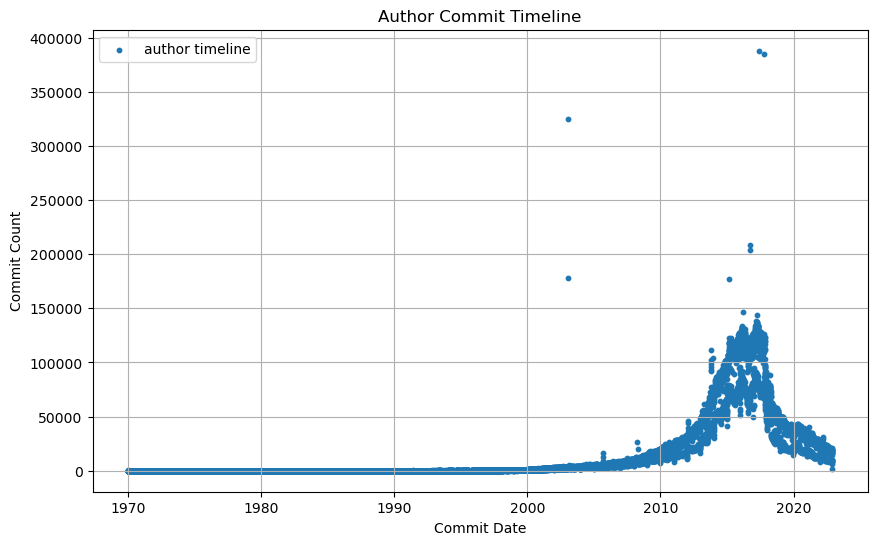

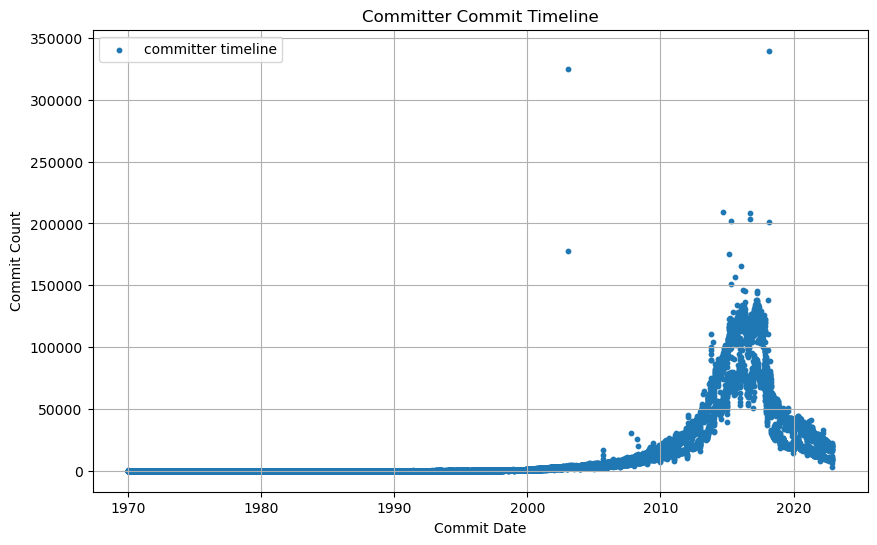

In [86]:
pdDf = [author_timeline_pdDf_filtered, committer_timeline_pdDf_filtered]
titles = ['author','committer']

for df, title in zip(pdDf, titles):
    x_col = f'{title}_commit_date'
    y_col = f'{title}_commit_count'
    
    df[x_col] = pd.to_datetime(df[x_col])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_col], df[y_col], marker='o',s=10, label=f'{title} timeline')
    
    # Adding labels and title
    plt.xlabel('Commit Date')
    plt.ylabel('Commit Count')
    plt.title(f'{title.capitalize()} Commit Timeline')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Popular Language Over Time

In [13]:
from pyspark.sql.functions import explode, col

# Step 1: Explode repo_name in commits_spDf
commits_exploded = commits_spDf.withColumn("repo_name_exploded", explode(col("repo_name")))

# Step 2: Join languages_spDf and exploded commits_spDf on repo_name
merged_df = languages_spDf.alias("lang").join(
    commits_exploded.alias("commit"),
    col("lang.repo_name") == col("commit.repo_name_exploded"),
    "inner"
)

# Step 3: Select relevant columns including time columns
result_df = merged_df.select(
    col("lang.repo_name").alias("repo_name"),           # from languages_spDf
    col("lang.language").alias("language"),            # from languages_spDf
    col("lang.language.bytes").alias("language_bytes"), # language bytes
    col("commit.author_commit_date").alias("author_commit_date"), # from commits_spDf
    col("commit.committer_commit_date").alias("committer_commit_date"), # from commits_spDf
)



In [14]:
language_time = result_df.groupBy(["committer_commit_date","language"]).agg(count("*").alias("Count"))

In [ ]:
# Step 4: Convert to Pandas for aggregation and plotting
result_pd = language_time.toPandas()

24/12/12 02:25:21 ERROR org.apache.spark.network.client.TransportResponseHandler: Still have 1 requests outstanding when connection from hub-msca-bdp-dphub-students-xiuan-sw-n7qj.c.msca-bdp-students.internal/10.128.0.156:43115 is closed
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:32797)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_23924/1269552853.py", line 2, in <module>
    result_pd = language_time.toPandas()
  File "/usr/lib/spark/python/pyspark/sql/pandas/conversion.py", line 141, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "/usr/lib/spark/python/pyspark/sql/dataframe.py", line 677, in collect
    sock_info = self._jdf.collectToPython()
  File "/opt/conda/miniconda3/lib/python3.8/site-packages/py4j/jav

In [ ]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/final_language_count.csv"
result_pd = result_pd.to_csv(bucket_write)

In [17]:
result_pd.head(5)

,committer_commit_date,committer_commit_date
0,2012-10-06,539872
1,2015-05-19,1213761
2,2013-03-26,1415912
3,2013-05-21,998647
4,2013-01-22,1238044


In [ ]:


# Step 5: Parse dates and aggregate
result_pd["author_commit_date"] = pd.to_datetime(result_pd["author_commit_date"])
result_pd["year_month"] = result_pd["author_commit_date"].dt.to_period("M")  # Group by year and month

# Aggregate data by language and time
trend_data = result_pd.groupby(["year_month", "language"]).agg({
    "language_bytes": "sum"
}).reset_index()

# Step 6: Save aggregated data to Pandas for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
top_languages = trend_data.groupby("language")["language_bytes"].sum().nlargest(5).index  # Top 5 languages
trend_plot_data = trend_data[trend_data["language"].isin(top_languages)]

# Plot trends
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=trend_plot_data,
    x="year_month",
    y="language_bytes",
    hue="language"
)
plt.title("Trends of Most Popular Programming Languages Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Total Bytes")
plt.legend(title="Language")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


# License distribution
What is the distribution of licenses across GitHub repositories?
Any certain programming languages that are more likely to be associated with a particular license?

In [ ]:
license_count = license_spDf.withColumn("Count",count('License'))
license_count.to_Panda()